# Tools for Link Analysis: urlExpander
View this on [GitHub](https://github.com/yinleon/links-as-data/blob/master/nbs/congress-links.ipynb) | [NBviewer](http://nbviewer.jupyter.org/github/yinleon/links-as-data/blob/master/nbs/congress-links.ipynb?flush_cache=true) | [Binder](https://mybinder.org/v2/gh/yinleon/links-as-data/master)<br>
Auhor: Leon Yin <br>
Updated on: 2018-10-01
<hr>

## Intro
This notebook will walk through using links as data
1. What kind of link data does Twitter provide?
2. How to extract link data from Tweets
3. Processing data by expanding shortened URLs
4. Unsupervised techniques
5. Supervised techniques

Software for this tutorial is found in this `requirements.txt` file.

## What Kind of Link Data Does Twitter Provide?
If you have neve looked at the backend of a Tweet here you go: [https://bit.ly/tweet_anatomy_link](https://bit.ly/tweet_anatomy_link). In addition to hashtags and the like, Tweets contain metadata fields for urls. The code below will show you how to extract and work with links from Tweets.

## Prereqs
Download software here:
```
pip install -r requirements.txt
```

Download data here:
```
python download_data.py
```

We're working with Tweets from memebers of congress collected by Greg Eady.

In [13]:
import os
import json
import glob
import itertools
from multiprocessing import Pool

from tqdm import tqdm
import pandas as pd
import urlexpander
from smappdragon import JsonCollection

from config import WORKING_DIRECTORY, INTERMEDIATE_DIRECTORY, \
                   RAW_TWEETS_DIRECTORY, CONGRESS_METADATA_DIRECTORY

In [14]:
# config setting
pd.options.display.float_format = '{:,.0f}'.format

# these are the files we'll be producing here
file_raw_links = os.path.join(INTERMEDIATE_DIRECTORY, 'links_raw.csv')
file_cache = os.path.join(INTERMEDIATE_DIRECTORY, 'cache.json')
file_expanded_links = os.path.join(INTERMEDIATE_DIRECTORY, 'links_expanded_all.csv')

# this is the raw data we're working with
files = glob.glob(os.path.join(RAW_TWEETS_DIRECTORY, '*.json.bz2'))
len(files)

1950

Let's preview one file. The file is saved as a newline-delimited json file like this
```
{"tweet_id" : "123", "more_data" : {"here" : "it is"}
{"tweet_id" : "124", "more_data" : {"here" : "it is again"}
```
and bzip2 compressed!

In [3]:
f = files[2]
f

'data/tweets-raw/1089859058__2018-03.json.bz2'

The file structure is identical to how we store all Tweet data at SMaPP. We developed software (like [smappdragon](https://github.com/SMAPPNYU/smappdragon)) to work with Tweets like this:

In [4]:
collect = JsonCollection(f, compression='bz2', throw_error=False, verbose=1)

smappdragon's `JsonCollection` class reads through JSON files as a [generator](https://wiki.python.org/moin/Generators).

In [5]:
collect

The con is that generators are hard to interpret, the pro is that they don't store any data in memory. We access the data on a row-by-row basis by iterating through the `collect` object. Here we only get the first row, we can see the contents by printing row:

In [6]:
for row in collect.get_iterator():
    break

In [7]:
#print(json.dumps(row, indent=2))

## How do we get the links?
Each Tweet can have more than one link, thus we need to unpack those values! urlexpander has a function to do just this:

In [8]:
?urlexpander.tweet_utils.get_link()

Signature: urlexpander.tweet_utils.get_link(tweet)
Docstring:
Returns a generator containing tweet metadata about media.

The metadata dict contains the following columns:

columns = {
  'link_domain' : 'the domain of the URL', 
  'link_url_long' : 'the URL (this can be short!)', 
  'link_url_short' : 'The t.co URL', 
  'tweet_created_at' : 'When the tweet was created', 
  'tweet_id' : 'The ID of the tweet', 
  'tweet_text' : 'The Full text of the tweet', 
  'user_id' : 'The Twitter ID of the tweeter'
}

:input tweet: a nested dictionary of a Tweet either from the streaming or search API.
:returns: a generator of dictionaries
File:      /anaconda3/lib/python3.6/site-packages/urlexpander/core/tweet_utils.py
Type:      function


Once again we have another generator

In [9]:
# returns a genrator, which is uninterpretable!
urlexpander.tweet_utils.get_link(row)

<generator object get_link at 0x111625d58>

In [10]:
# we can access the data by iterating through it.
for link_meta in urlexpander.tweet_utils.get_link(row):
    print(link_meta)

{'user_id': 1089859058, 'tweet_id': 976517212063322112, 'tweet_created_at': 'Wed Mar 21 17:53:40 +0000 2018', 'tweet_text': None, 'link_url_long': 'http://bit.ly/2FC7bMz', 'link_domain': 'bit.ly', 'link_url_short': 'https://t.co/5P1JAaxwQV'}


In [11]:
# to unwrap this we'll do this mess of cose
list(itertools.chain.from_iterable([urlexpander.tweet_utils.get_link(row)]))

[{'link_domain': 'bit.ly',
  'link_url_long': 'http://bit.ly/2FC7bMz',
  'link_url_short': 'https://t.co/5P1JAaxwQV',
  'tweet_created_at': 'Wed Mar 21 17:53:40 +0000 2018',
  'tweet_id': 976517212063322112,
  'tweet_text': None,
  'user_id': 1089859058}]

This is one way of unpacking links from a Tweet json:

In [12]:
data = []
for f in tqdm(files[:2]):
    # read the json file into a generator
    collection = JsonCollection(f, compression='bz2', throw_error=False)
    
    # iterate through the json file, extract links, flatten the generator of links
    # into a list, and store into a Pandas dataframe
    df_ = pd.DataFrame(list(
            itertools.chain.from_iterable(
                [urlexpander.tweet_utils.get_link(t) 
                 for t in collection.get_iterator() 
                 if t]
            ))
    )
    df_['file'] = f
    data.extend(df_.to_dict(orient='records'))

100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


## But with many files it is slow, so here's a faster paralellized way:

In [13]:
def read_file_extract_links(f):
    '''
    This function takes in a Tweet file that bzip2-compressed, 
    newline-deliminted json, and returns a list of dictionaries
    for link data.
    '''
    # read the json file into a generator
    collection = JsonCollection(f, compression='bz2', throw_error=False)
    
    # iterate through the json file, extract links, flatten the generator of links
    # into a list, and store into a Pandas dataframe
    df_ = pd.DataFrame(list(
            itertools.chain.from_iterable(
                [urlexpander.tweet_utils.get_link(t) 
                 for t in collection.get_iterator() 
                 if t]
            )))
    df_['file'] = f
    return df_.to_dict(orient='records')

In [18]:
N_CPU = 4
if not os.path.exists(file_raw_links):
    data = []
    with Pool(N_CPU) as pool:
        iterable = pool.imap_unordered(read_file_extract_links, files)
        for link_data in tqdm(iterable, total=len(files)):
            data.extend(link_data)
    print(len(data))
    
    df_links = pd.DataFrame(data)
    df_links.to_csv(file_raw_links, index=False)
else:
    df_links = pd.read_csv(file_raw_links)

df_links.head(2)

,file,link_domain,link_url_long,link_url_short,tweet_created_at,tweet_id,tweet_text,user_id
0,/scratch/olympus/projects/mediascore/Data/json...,frc.org,https://www.frc.org/wwlivewithtonyperkins/rep-...,https://t.co/l9dXT0L7oT,Fri Mar 23 14:38:34 +0000 2018,977192888781168640,NaN,2966758114
1,/scratch/olympus/projects/mediascore/Data/json...,thehill.com,http://thehill.com/379188-watch-fund-governmen...,https://t.co/YbdvepWNQ3,Thu Mar 22 15:21:32 +0000 2018,976841314024206339,NaN,2966758114


The bulk of URLs we encounter in the wild are sent through a link shortener. Link shorteners record transactional information whenever that link is clicked. Unfortunately it makes it hard for us to see what was being shared.

In [19]:
links = df_links['link_url_long'].tolist()
links[-5:]

['http://goo.gl/kDUwP',
 'http://bit.ly/12clU3p',
 'http://nyti.ms/Z4rdlU',
 'http://goo.gl/LxkrY',
 'http://www.huffingtonpost.com/rep-diana-degette/reducing-gun-violence-mea_b_3018506.html']

This is why urlexpander was made. We can run it on both single URLs, as well as a list of URLs.

In [24]:
urlexpander.expand(links[-5])

'https://degette.house.gov/index.php?option=com_content&view=article&id=1260:congressional-lgbt-equality-caucus-praises-re-introduction-of-employment-non-discrimination-act&catid=76:press-releases-&Itemid=227'

In [25]:
urlexpander.expand(links[-5:])

['https://degette.house.gov/index.php?option=com_content&view=article&id=1260:congressional-lgbt-equality-caucus-praises-re-introduction-of-employment-non-discrimination-act&catid=76:press-releases-&Itemid=227',
 'http://www.rollcall.com/news/house_hydro_bill_tests_water_for_broad_energy_deals-224277-1.html',
 'https://www.nytimes.com/2013/04/18/opinion/a-senate-in-the-gun-lobbys-grip.html?smid=tw-share',
 'http://www.civiccenterconservancy.org/history-2012-nhl-designation_25.html',
 'http://huffingtonpost.com/__CLIENT_ERROR__']

## What's happening behind the scenes? 
['abc.com/123', 'bbc.co.uk/123', 'abc.com/123', 'bit.ly/cbc23']<br>
--> Remove duplicates<br>
 ['abc.com/123', 'bbc.co.uk/123', 'bit.ly/cbc23']<br>
--> Filter for shortened URLs<br>
['bit.ly/cbs23']<br>
--> unshorten<br>
[{'original_url': 'bit.ly/cbs23', 'resolved' : 'cspan.com/123'}]<br>
--> join back in<br>
['abc.com/123', 'bbc.co.uk/123', 'abc.com/123', 'cspan.com/123']<br>

urlexpander parallelizes, filters and caches the input, which is essential for social media data.

In [26]:
?urlexpander.expand()

Signature: urlexpander.expand(links_to_unshorten, chunksize=1280, n_workers=1, cache_file=None, random_seed=303, verbose=0, filter_function=None, **kwargs)
Docstring:
Calls expand with multiple (``n_workers``) threads to unshorten a list of urls. Unshortens all urls by default, unless one sets a ``filter_function``.

:param links_to_unshorten: (list, str) either an idividual or list (str) of urls to unshorten
:param chunksize: (int) chunks links_to_unshorten, which makes computation quicker with larger inputs
:param n_workers: (int) how many threads
:param cache_file: (str) a path to a json file to read and write results in
:param random_seed: (int) initializes the random state for shuffling the input
:param verbose: (int) whether to print updates and errors. 0 is silent. 1 is progress bar. 2 is progress bar and errors.
:param filter_function: (func) a boolean used to filter url shorteners out
    

:returns: (list) a list of resolved urls
File:      /anaconda3/lib/python3.6/site-packa

In [33]:
resolved_urls = urlexpander.expand(links, 
                                   filter_function=urlexpander.is_short,
                                   n_workers=64,
                                   chunksize=1280,
                                   cache_file=file_cache,
                                   verbose=1)

In [51]:
len(resolved_urls)

1700150

In [52]:
df_links['link_resolved'] = resolved_urls
df_links['link_resolved_domain'] = df_links['link_resolved'].apply(urlexpander.get_domain)

In [254]:
df_links.to_csv(file_expanded_links), index=False)

## Analytics

In [15]:
df_links = pd.read_csv(file_expanded_links)
df_links.head(2)

,file,link_domain,link_url_long,link_url_short,tweet_created_at,tweet_id,tweet_text,user_id,link_resolved,link_resolved_domain
0,/scratch/olympus/projects/mediascore/Data/json...,frc.org,https://www.frc.org/wwlivewithtonyperkins/rep-...,https://t.co/l9dXT0L7oT,Fri Mar 23 14:38:34 +0000 2018,977192888781168640,NaN,2.966758e+09,https://www.frc.org/wwlivewithtonyperkins/rep-...,frc.org
1,/scratch/olympus/projects/mediascore/Data/json...,thehill.com,http://thehill.com/379188-watch-fund-governmen...,https://t.co/YbdvepWNQ3,Thu Mar 22 15:21:32 +0000 2018,976841314024206339,NaN,2.966758e+09,https://thehill.com/379188-watch-fund-governme...,thehill.com


We can get an overview of the most frequently shared domains:

In [16]:
df_links['link_resolved_domain'].value_counts().head(15)

twitter.com           255532
house.gov             199218
youtube.com            93986
facebook.com           90061
senate.gov             78645
washingtonpost.com     29886
instagram.com          28460
nytimes.com            25014
thehill.com            22925
politico.com           13488
foxnews.com            12045
cnn.com                11611
wsj.com                11289
twimg.com               9633
ow.ly                   9463
Name: link_resolved_domain, dtype: int64

### Text-based URL Metadata
Twitter provides URL metadata ([if you pay](https://developer.twitter.com/en/docs/tweets/enrichments/overview/expanded-and-enhanced-urls)), we provided a workaround!

In [12]:
url = 'http://www.rollcall.com/news/house_hydro_bill_tests_water_for_broad_energy_deals-224277-1.html'
meta = urlexpander.html_utils.get_webpage_meta(url)
meta

OrderedDict([('url',
              'http://www.rollcall.com/news/house_hydro_bill_tests_water_for_broad_energy_deals-224277-1.html'),
             ('title', 'House Hydro Bill Tests Water for Broad Energy Deals'),
             ('description',
              ' In February, the House did something rare: It passed an energy bill unanimously. Unlike the previous Congress’ standard fare of anti-EPA, pro-drilling measures, the first energy bill of the 113th Congress promoted small-scale hydropower projects and the electrification of existing dams.'),
             ('paragraphs',
              ['',
               '',
               'In February, the House did something rare: It passed an energy bill unanimously. Unlike the previous Congress’ standard fare of anti-EPA, pro-drilling measures, the first energy bill of the 113th Congress promoted small-scale hydropower projects and the electrification of existing dams.',
               'In other words, the Republican-controlled House passed a clean-

### User Activity in Aggregate
The frequency of domains shared per-user make rich features. We can aggregate the data using the following utility function:

In [38]:
count_matrix = urlexpander.tweet_utils.count_matrix(
      df_links,
      user_col='user_id',
      domain_col='link_resolved_domain',
      min_freq=20,
)

count_matrix.head()

,1011fmtheanswer.com,10best.com,10tv.com,11alive.com,123formbuilder.com,12news.com,12newsnow.com,13abc.com,13wham.com,13wmaz.com,...,yorkdispatch.com,youarecurrent.com,youcaring.com,youngcons.com,yourconroenews.com,yourdailyjournal.com,youtube.com,zeldinforcongress.com,zeldinforsenate.com,zpolitics.com
user_id,,,,,,,,,,,,,,,,,,,,,
813286.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,198,0,0,0
939091.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,106,0,0,0
5496932.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,427,0,0,0
5511752.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,73,0,0,0
5558312.0,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,53,0,0,0


## Machine Learning
Let's see how the `count_matrix` features fair in machine learning. Do do so, we need to enrich our data with a field. For our purposes, we will use the political affiliation.

In [41]:
%matplotlib inline
import umap
import matplotlib.pyplot as plt

These files have the affiliation of each account.

In [46]:
meta = []
for f in glob.glob(os.path.join(CONGRESS_METADATA_DIRECTORY, '*')):
    _df = pd.read_csv(f)
    _df = _df[~_df.twitter_id.isnull()]
    meta.extend(_df.to_dict(orient='records'))

In [47]:
df_meta = pd.DataFrame(meta)
df_meta.twitter_id = df_meta.twitter_id.astype(float, errors='ignore').astype(str)
df_links.user_id = df_links.user_id.astype(float, errors='ignore').astype(str)
look_up = df_meta[df_meta['twitter_id'].isin(df_links.user_id)].drop_duplicates(subset=['twitter_id'])[['twitter_id', 'affiliation']]
df_links_ = df_links[df_links.user_id.isin(look_up['twitter_id'])]

In [48]:
len(df_links_.user_id.unique()), len(look_up)

(971, 971)

## Unsupervised Learning
This will be an exploratory step, where we will try to visualze the dataset of counts of links shared by user. We will reduce the high-dimensional data (where each domain is one dimension) to two-dimensions for visualization using the [UMAP](https://umap-learn.readthedocs.io/en/latest/) algorithm (much like the populat [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm).

In [73]:
def color(party):
    if party == 'Democrat':
        return 'blue' 
    elif party == 'Republican':
        return 'red'
    else:
        return 'black'

def viz_umap_embed(count_matrix, title="Members of Congress Embedded by UMAP", threshold=5, **kwargs):
    '''
    Visualizes the count matrix in 2 dimensions using UMAP.
    '''
    if threshold:
        count_matrix = count_matrix[count_matrix.sum(axis=1) >= threshold]
    parties = look_up.set_index('twitter_id').loc[count_matrix.index].affiliation

    embedding = umap.UMAP(n_components=2, **kwargs).fit_transform(count_matrix.values)

    plt.figure(figsize=(14,8))
    ax = plt.scatter(x = embedding[:,0], 
                     y = embedding[:,1],
                     s = 100,
                     c = parties.apply(color),
                     alpha = .4)

    plt.title(title)
    plt.axis('off')
    plt.show()

In [37]:
exclude = ['youtube.com', 'twitter.com', 'fb.com', 
           'facebook.com', 'instagram.com', 'ow.ly', 
           'house.gov', 'senate.gov', 'usa.gov']

In [123]:
count_matrix = urlexpander.tweet_utils.count_matrix(
      df_links_,
      user_col='user_id',
      domain_col='link_resolved_domain',
      min_freq=5,
      exclude_domain_list=exclude,
)

In [124]:
count_matrix.head(2)

,frc.org,thehill.com,iheart.com,c-span.org,news9.com,speaker.gov,foxnews.com,frcaction.org,koco.com,okcfox.com,...,mullinforcongress.com,therepublicanstandard.com,barbaracomstockforcongress.com,thefriendshipchallenge.com,tomreedforcongress.com,sincomillas.com,detodopr.com,thedowneypatriot.com,garretgravesforcongress.com,about.com
user_id,,,,,,,,,,,,,,,,,,,,,
1004855106.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009269193.0,0,12,0,16,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


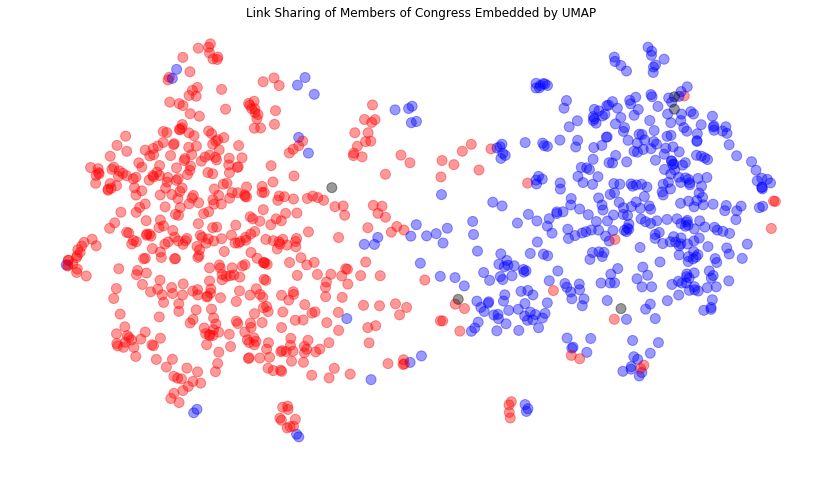

In [125]:
viz_umap_embed(count_matrix, 
               title="Link Sharing of Members of Congress Embedded by UMAP",
               threshold=5,
               # umap params
               n_neighbors=50,
               min_dist=0.1,
               metric='dice',
               random_state=303)

## Supervised Learning
In the unsupervised case, we already see Democrats and Republicans sectioned off. Here we will fit a [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict whether a congress member is a democrat or a republican based on the `count_matrix` we just created.

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [132]:
# filter out independents, and accounts that sent less than one link!
dems_repubs = look_up[look_up.affiliation != 'Independent'].twitter_id
count_matrix_ = count_matrix[(count_matrix.index.isin(dems_repubs)) &
                             (count_matrix.sum(axis=1) >= 1)]
parties = look_up.set_index('twitter_id').loc[count_matrix_.index].affiliation

# create the training set
X, y = count_matrix_.values, parties
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=303, test_size=.15)
len(X_train), len(X_test) 

(820, 145)

In [137]:
logreg = LogisticRegression(penalty='l2', C=.7,
                            solver='liblinear',
                            random_state=303)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.9517241379310345

## Evaluation

In [59]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[49  2]
 [ 5 89]]
Normalized confusion matrix
[[0.96 0.04]
 [0.05 0.95]]


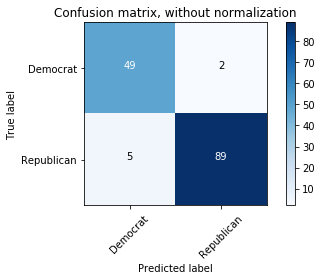

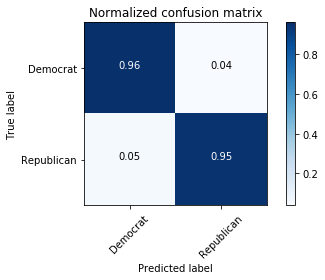

In [138]:
y_pred = logreg.predict(X_test)
class_names = logreg.classes_

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [139]:
# these are what we got wrong!
df_meta.set_index('twitter_id').loc[
    y_test[y_test != y_pred].index
][['twitter_name']]

,twitter_name
twitter_id,
9.410800851211756e+17,SenDougJones
23820360.0,billhuizenga
136526394.0,WebsterCongress
4615689368.0,GeneGreen29
19726613.0,SenatorCollins
242376736.0,RepCharlieDent
16056306.0,JeffFlake


In [140]:
indep = look_up[look_up.affiliation == 'Independent'].twitter_id
count_matrix_indep_ = count_matrix[(count_matrix.index.isin(indep)) &
                                   (count_matrix.sum(axis=1) >= 2)]

In [141]:
df_ind = df_meta.set_index('twitter_id').loc[count_matrix_indep_.index][['twitter_name']]
df_ind['preds'] = logreg.predict(count_matrix_indep_)
df_ind

,twitter_name,preds
twitter_id,,
1068481578.0,SenAngusKing,Republican
216776631.0,BernieSanders,Democrat
2915095729.0,AkGovBillWalker,Republican
29442313.0,SenSanders,Democrat
3196634042.0,GovernorMapp,Republican
